#  (Nguyen Tuong Ha - nguyenpanda)
- Dataset link: [Kaggle]()

# Table of Contents
<!-- TOC -->
* [(Nguyen Tuong Ha - nguyenpanda)](#nguyen-tuong-ha---nguyenpanda)
* [Table of Contents](#table-of-contents)
* [0. Setup](#0-setup)
  * [0.0. Install packages](#00-install-packages)
  * [0.1. Checking running environment](#01-checking-running-environment)
    * [Download dataset from Kaggle](#download-dataset-from-kaggle)
    * [Creating a symbolic link (alias) to an exist directory](#creating-a-symbolic-link-alias-to-an-exist-directory)
<!-- TOC -->

# 0. Setup

## 0.0. Install packages

In [283]:
!pip install nguyenpanda kaggle torchmetrics torchinfo mlxtend opencv-python opencv-contrib-python timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 8.1 MB/s eta 0:00:00a 0:00:01


In [3]:
import torch
import torchvision

from torch import nn
from torch import optim
from torchmetrics import ConfusionMatrix
from torch.utils import data as torch_data
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data.dataloader import default_collate

from torchvision import datasets
from torchvision import transforms

from torchinfo import summary

In [284]:
import timm

In [9]:
import albumentations as A
import numpy as np
import pandas as pd
import mlxtend as mle
import cv2
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import nguyenpanda
from nguyenpanda.swan import color, green, yellow
import nguyenpanda.crow as crow
from PIL import Image
from IPython import display
from tqdm.notebook import tqdm
from mlxtend.plotting import plot_confusion_matrix
from pathlib import Path

import os
import sys
import importlib
import random
import typing_extensions as te

## 0.1. Checking running environment

In [337]:
DEVICE = ('cuda' if torch.cuda.is_available() else
          'mps' if torch.backends.mps.is_available() else
          'cpu')
print('DEVICE:', green(DEVICE))

CPUs = os.cpu_count()
print('CPUs:', green(CPUs))

# print(plt.style.available)
plt.style.use('dark_background')

IN_COLAB: bool = crow.nbu.is_colab()
MY_DRIVE: te.Optional[Path] = crow.gcu.mount_google_drive()

DEVICE: cpu
CPUs: 8


### Creating a symbolic link (alias) to an exist directory

In [7]:
# For creating a symbolic link (alias) to an existing directory
dataset: crow.Dataset = crow.Dataset(
    name='datasets'  # By default: None
)

dataset: crow.Dataset = dataset.alias(
    source=crow.Dataset.bfs_find('object-localization-dataset-master', search_path=Path.home()),
    # By default: `source` is None (if None, alias name is '<dataset-alias-name>' provided at Dataset constructor
    # Either `name` or `source` must be provided, else a ValueError is raised. 
    destination=Path.cwd(),  # By default: Path.cwd()
    verbose=True,  # By default: True
)

DATASET_SOURCE_DIR: Path = dataset.dataset_source_dir

Creating an alias /Users/hatuongnguyen/datasets/object-localization-dataset-master -> /Users/hatuongnguyen/Learning/PyTorch/model/Localization/datasets


In [97]:
CSV_PATH: Path = DATASET_SOURCE_DIR / 'train.csv'
df = pd.read_csv(CSV_PATH)
df['img_path'] = DATASET_SOURCE_DIR / df['img_path']
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,/Users/hatuongnguyen/datasets/object-localizat...,24,23,202,183,227,227,mushroom
1,/Users/hatuongnguyen/datasets/object-localizat...,34,34,88,201,227,227,eggplant
2,/Users/hatuongnguyen/datasets/object-localizat...,49,86,183,185,227,227,mushroom
3,/Users/hatuongnguyen/datasets/object-localizat...,51,59,191,164,227,227,eggplant
4,/Users/hatuongnguyen/datasets/object-localizat...,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,/Users/hatuongnguyen/datasets/object-localizat...,67,22,177,215,227,227,eggplant
182,/Users/hatuongnguyen/datasets/object-localizat...,11,31,217,208,227,227,cucumber
183,/Users/hatuongnguyen/datasets/object-localizat...,93,13,158,193,227,227,mushroom
184,/Users/hatuongnguyen/datasets/object-localizat...,21,59,192,171,227,227,eggplant


In [129]:
CLASSES_TO_IDX = {k: v for v, k in enumerate(sorted(df['label'].unique()))}
CLASSES_TO_IDX

{'cucumber': 0, 'eggplant': 1, 'mushroom': 2}

In [322]:
def plot_image_with_bbox(image: te.Union[np.ndarray, torch.Tensor, Path, str],
                         bbox: te.Optional[list[tuple[int, int]] | torch.Tensor] = None):
    if isinstance(image, (Path, str)):
        image = cv2.imread(str(image))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    elif isinstance(image, torch.Tensor):
        if image.ndim == 3:
            image = image.permute((1, 2, 0)).cpu().numpy()
        if image.ndim == 4:
            image = image.squeeze().cpu().numpy()
        image = (image * 255).astype(np.uint8)

    if bbox is not None:
        if isinstance(bbox, torch.Tensor):
            bbox = bbox.tolist()
            bbox = [(bbox[i], bbox[i + 1]) for i in range(0, 3, 2)]
        bbox = [(int(round(x, 0)), int(round(y, 0))) for x, y in bbox]
        cv2.rectangle(image, bbox[0], bbox[1], (255, 0, 0), 2)

    plt.grid(False)
    plt.axis(False)
    plt.imshow(image)
    plt.show()

    return image

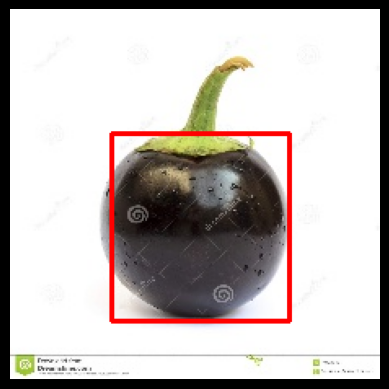

In [269]:
row = df.iloc[random.randint(0, len(df) - 1)]
img = plot_image_with_bbox(row.img_path, [(row.xmin, row.ymin), (row.xmax, row.ymax)])

In [221]:
train_df, test_df = sklearn.model_selection.train_test_split(df, test_size=0.2, shuffle=True)
len(train_df), len(test_df)

(148, 38)

In [222]:
train_transform = A.Compose([
    A.Resize(140, 140),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

test_transform = A.Compose([
    A.Resize(140, 140),
    A.Rotate()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

In [223]:
train_transform(image=img, bboxes=((row.xmin, row.ymin, row.xmax, row.ymax),), class_labels=[row.label])

{'image': array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255,

In [224]:
class LocalizationDataset(Dataset):

    def __init__(self, dataframe: pd.DataFrame, transform: A.Compose = None):
        self.df = dataframe
        self.transform = transform
        self.cls_to_idx = CLASSES_TO_IDX

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, item) -> tuple[torch.Tensor, torch.Tensor]:
        _row = self.df.iloc[item]

        _img = cv2.imread(_row.img_path)
        cv2.cvtColor(_img, cv2.COLOR_BGR2RGB, _img)
        _bboxes = [(_row.xmin, _row.ymin, _row.xmax, _row.ymax)]
        # _label = _row.label

        if self.transform:
            _data = self.transform(image=_img, bboxes=_bboxes, class_labels=[None])
            _img = _data['image']
            _bboxes = _data['bboxes'][0]
            # _label = _data['class_labels'][0]

        _img = torch.from_numpy(_img).permute(dims=(2, 0, 1)) / 255.0
        _bboxes = torch.Tensor(_bboxes)
        # _label = torch.Tensor(self.cls_to_idx[_label]).type(torch.int)

        return _img, _bboxes


In [225]:
train_dataset = LocalizationDataset(dataframe=train_df, transform=train_transform)
test_dataset = LocalizationDataset(dataframe=test_df, transform=test_transform)

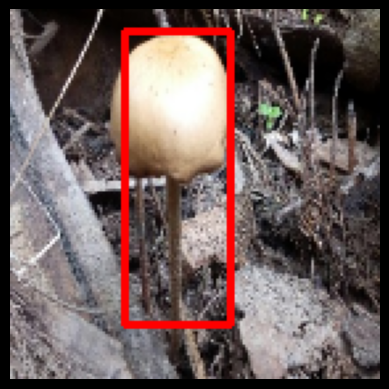

In [276]:
idx = random.randint(0, len(train_df) - 1)
img, label = train_dataset[idx]
_ = plot_image_with_bbox(img, label)

In [277]:
BATCH_SIZE: int = 32


def collate_func(batch_list: list[tuple[torch.Tensor, torch.Tensor]]):
    return tuple(tensor.to(DEVICE) for tensor in default_collate(batch_list))


train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_func)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_func)

In [282]:
temp = next(iter(train_loader))
print(temp[0].shape, temp[1].shape)

temp = next(iter(train_loader))
print(temp[0].shape, temp[1].shape)

print(len(train_loader), len(test_loader))

torch.Size([32, 3, 140, 140]) torch.Size([32, 4])
torch.Size([32, 3, 140, 140]) torch.Size([32, 4])
5 2


In [302]:
class LocalizationModel(nn.Module):

    def __init__(self, model_name: str = 'efficientnet_b0'):
        super().__init__()
        self.backbone = timm.create_model(model_name=model_name, pretrained=True, num_classes=4)

    def forward(self, x, gt_bboxes=None):
        bboxes = self.backbone(x)

        if gt_bboxes is not None:
            loss = nn.MSELoss()(bboxes, gt_bboxes)
            return bboxes, loss

        return bboxes

    def run_train(self, dataloader, optimizer: optim.Adam):
        total_loss = 0.0
        self.train()

        for image, gt_bboxes in tqdm(dataloader):
            bboxes, loss = self.forward(image, gt_bboxes)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        return total_loss / len(dataloader)

    def run_eval(self, dataloader):
        total_loss = 0.0
        self.eval()

        with torch.inference_mode():
            for image, gt_bboxes in tqdm(dataloader):
                bboxes, loss = self.forward(image, gt_bboxes)
                total_loss += loss.item()

        return total_loss / len(dataloader)

In [303]:
model = LocalizationModel().to(DEVICE)

In [305]:
random_img = torch.rand(1, 3, 140, 140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

In [306]:
EPOCHS: int = 40
LR: float = 0.001

In [307]:
opti = optim.Adam(model.parameters(), lr=LR)

In [308]:
best_loss = np.Inf

for i in range(EPOCHS):
    train_loss = model.run_train(train_loader, opti)
    eval_loss = model.run_eval(test_loader)

    if eval_loss < best_loss:
        torch.save(model.state_dict(), 'best_localization.pt')
        print('Saving model')
        best_loss = eval_loss

    print(f'Epoch {i: > 3}: train_loss={train_loss: >10.5f}, eval_loss={eval_loss: >10.5f}')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saving model
Epoch   0: train_loss=6589.47539, eval_loss=3545.62891


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch   1: train_loss=3592.12949, eval_loss=3694.35449


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch   2: train_loss=2020.35698, eval_loss=6416.12427


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saving model
Epoch   3: train_loss=1439.95645, eval_loss=2729.33582


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saving model
Epoch   4: train_loss=1035.54159, eval_loss=1166.84311


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saving model
Epoch   5: train_loss= 835.37242, eval_loss= 462.64572


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saving model
Epoch   6: train_loss= 655.67696, eval_loss= 239.72547


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saving model
Epoch   7: train_loss= 542.06862, eval_loss= 206.89954


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saving model
Epoch   8: train_loss= 476.38592, eval_loss= 170.34094


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch   9: train_loss= 387.60599, eval_loss= 213.31593


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saving model
Epoch  10: train_loss= 356.32655, eval_loss= 164.73339


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch  11: train_loss= 309.97245, eval_loss= 186.62507


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch  12: train_loss= 257.59948, eval_loss= 235.52178


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch  13: train_loss= 212.97292, eval_loss= 207.55862


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch  14: train_loss= 160.32339, eval_loss= 184.49036


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saving model
Epoch  15: train_loss= 173.18132, eval_loss= 159.39756


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch  16: train_loss= 145.10900, eval_loss= 179.43386


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch  17: train_loss= 110.59753, eval_loss= 163.96705


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saving model
Epoch  18: train_loss= 103.10189, eval_loss= 133.12049


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch  19: train_loss=  88.84273, eval_loss= 164.89013


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch  20: train_loss=  81.09534, eval_loss= 139.37020


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saving model
Epoch  21: train_loss=  83.45730, eval_loss= 110.97170


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saving model
Epoch  22: train_loss=  73.28424, eval_loss= 110.74884


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saving model
Epoch  23: train_loss=  62.15635, eval_loss= 103.15179


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch  24: train_loss=  70.08829, eval_loss= 131.56974


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch  25: train_loss=  54.95215, eval_loss= 130.10931


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch  26: train_loss=  52.66136, eval_loss= 132.91314


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saving model
Epoch  27: train_loss=  55.32870, eval_loss=  87.29134


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saving model
Epoch  28: train_loss=  46.79948, eval_loss=  82.14555


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch  29: train_loss=  38.02778, eval_loss= 109.87696


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saving model
Epoch  30: train_loss=  40.75293, eval_loss=  68.99435


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saving model
Epoch  31: train_loss=  46.81666, eval_loss=  50.49883


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch  32: train_loss=  28.94495, eval_loss=  88.53907


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch  33: train_loss=  42.04761, eval_loss= 118.72335


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch  34: train_loss=  26.81490, eval_loss=  68.73254


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch  35: train_loss=  33.58563, eval_loss=  63.23399


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch  36: train_loss=  29.79244, eval_loss=  63.69611


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch  37: train_loss=  24.85502, eval_loss=  76.23686


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch  38: train_loss=  30.20864, eval_loss=  90.59539


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch  39: train_loss=  26.31992, eval_loss=  76.52708


In [310]:
loaded_model = LocalizationModel()
loaded_model.load_state_dict(torch.load('best_localization.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [342]:
def plot_eval_image(image: te.Union[np.ndarray, torch.Tensor, Path, str],
                    bbox_true: list[tuple[int, int]] | torch.Tensor,
                    bbox_pred: list[tuple[int, int]] | torch.Tensor):
    if isinstance(image, (Path, str)):
        image = cv2.imread(str(image))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    elif isinstance(image, torch.Tensor):
        if image.ndim == 3:
            image = image.permute((1, 2, 0)).cpu().numpy()
        if image.ndim == 4:
            image = image.squeeze().cpu().numpy()
        image = (image * 255).astype(np.uint8)

    if isinstance(bbox_true, torch.Tensor):
        bbox = bbox_true.tolist()
        bbox = [(bbox[i], bbox[i + 1]) for i in range(0, 3, 2)]
    bbox = [(int(round(x, 0)), int(round(y, 0))) for x, y in bbox]
    cv2.rectangle(image, bbox[0], bbox[1], (255, 0, 0), 2)
    
    if isinstance(bbox_pred, torch.Tensor):
        bbox = bbox_pred.tolist()
        bbox = [(bbox[i], bbox[i + 1]) for i in range(0, 3, 2)]
    bbox = [(int(round(x, 0)), int(round(y, 0))) for x, y in bbox]
    cv2.rectangle(image, bbox[0], bbox[1], (0, 0, 255), 2)

    plt.title(f'Red = bbox_true, Blue = bbox_pred')
    plt.grid(False)
    plt.axis(False)
    plt.imshow(image)
    plt.show()

    return image

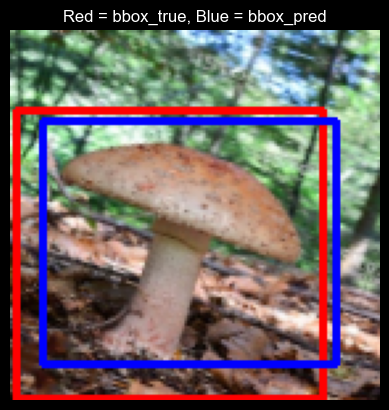

In [355]:
loaded_model.eval()
with torch.inference_mode():
    img, gt_bbox = test_dataset[random.randint(0, len(test_dataset) - 1)]
    img = img.unsqueeze(0).to(DEVICE)
    out_bbox = loaded_model(img)[0]

_ = plot_eval_image(img[0], gt_bbox, out_bbox)